In [ ]:
import requests
import os
import zipfile
import time
from datetime import date


def real_estate(year, season):
    
    url = "https://plvr.land.moi.gov.tw//DownloadSeason?season={}S{}&type=zip&fileName=lvr_landcsv.zip".format(str(year),str(season))
    res = requests.get(url, 'lxml')
    
    file_name = str(year)+str(season)+'.zip'
    open(file_name, 'wb').write(res.content)
    
    folder = 'real_estate' + str(year) + str(season)
    if not os.path.isdir(folder):
        os.mkdir(folder)
    
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(folder)
    os.remove(file_name)
    time.sleep(10)
    
year = 101
the_year = date.today().year-1911

while the_year >= year:
    for season in range(1,5):
        folder = 'real_estate' + str(year) + str(season)
        if os.path.exists('./'+folder):
            continue
        else:
            try:
                real_estate(year, season)
            except Exception as e:
                break
    year += 1

In [1]:
import pandas as pd
import os

folders = [folder for folder in os.listdir() if folder[:4]=='real']

dfs = list()
for folder in folders:
    try:
        df = pd.read_csv(os.path.join(folder,'a_lvr_land_a.csv'), index_col=False)
        df['Q'] = folder[-1]
        dfs.append(df.iloc[1:])
    except FileNotFoundError as e:
        print(e)
df = pd.concat(dfs, sort=True)

[Errno 2] No such file or directory: 'real_estate1011/a_lvr_land_a.csv'
[Errno 2] No such file or directory: 'real_estate1012/a_lvr_land_a.csv'
[Errno 2] No such file or directory: 'real_estate1013/a_lvr_land_a.csv'


In [2]:
# 單價整理與換算
df['單價元坪'] = df['單價元平方公尺'].astype(float)*3.30579
# 整理建物型態資料，刪除有備註之交易（多為親友交易、價格不正常之交易）
df['建物型態2'] = df['建物型態'].str.split('(').str[0]
df = df[df['備註'].isnull()]
# 新增交易年份
df['year'] = df['交易年月日'].str[:-4].astype(int)+1911
df['交易日期'] = pd.to_datetime((df['交易年月日'].str[:-4].astype(int)+1911).astype(str)+df['交易年月日'].str[-4:],errors='coerce')

In [3]:
df.isnull().sum()

Q                     0
主建物面積                 0
主要建材              13612
主要用途              16233
交易年月日                 0
交易標的                  0
交易筆棟數                 0
備註               128409
單價元平方公尺            8336
土地位置建物門牌              0
土地移轉總面積平方公尺           0
建物型態                  0
建物現況格局-廳              0
建物現況格局-房              0
建物現況格局-衛              0
建物現況格局-隔間             0
建物移轉總面積平方公尺           0
建築完成年月            23298
有無管理組織                0
移轉層次              13668
移轉編號             125382
編號                    0
總價元                   0
總樓層數              13790
車位移轉總面積(平方公尺)         0
車位總價元                 0
車位類別              79022
都市土地使用分區            878
鄉鎮市區                  0
附屬建物面積                0
陽台面積                  0
電梯               113585
非都市土地使用分區        128385
非都市土地使用編定        128409
單價元坪               8336
建物型態2                 0
year                  0
交易日期                 14
dtype: int64

In [4]:
# 處理遺失值
df2=df[df.交易日期.notnull() & df.單價元平方公尺.notnull() ]
df2.index = df2['交易日期']

In [5]:
df2 = df2.drop(['交易日期'], axis=1)

In [6]:
df2.year.value_counts()

2013    22365
2014    15795
2015    11925
2012    11115
2020    10235
2019    10046
2016     9946
2017     9819
2018     9661
2021     7408
2010      859
2011      623
2009      253
2008        6
2004        1
2006        1
2003        1
Name: year, dtype: int64

In [8]:
# 只取資料量夠多的年份
df2 = df2[df2.year > 2008]

## 分析目的：每年房價變化
欄位：
- 每坪房價
- 物件型態
- 鄉鎮市區

In [34]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, date

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 60)

import matplotlib.pyplot as plt
plt.rcParams['font.family']='sans-serif' 
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

seedval = 111111

### 每年房價走勢圖
```
瞭解地區、時間這兩個因子對於房價的差異
```

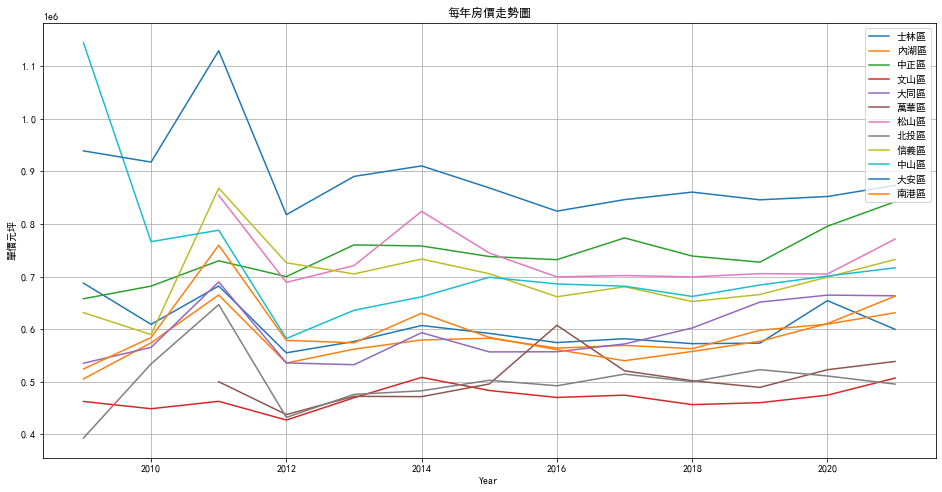

In [41]:
prices = {}
for district in set(df2['鄉鎮市區']):
    cond = (
        (df2['主要用途'] == '住家用')
        & (df2['鄉鎮市區'] == district)
        & (df2['單價元坪'] < df2["單價元坪"].quantile(0.95))
        & (df2['單價元坪'] > df2["單價元坪"].quantile(0.05))
        )
    
    groups = df2[cond]['year']
    
    prices[district] = df2[cond]['單價元坪'].astype(float).groupby(groups).mean()

price_history = pd.DataFrame(prices)
ax = price_history.plot(title='每年房價走勢圖', figsize=(16,8), grid=True)
ax.legend(loc='upper right')
# plt.grid(True)
plt.xlabel('Year')
plt.ylabel('單價元坪');

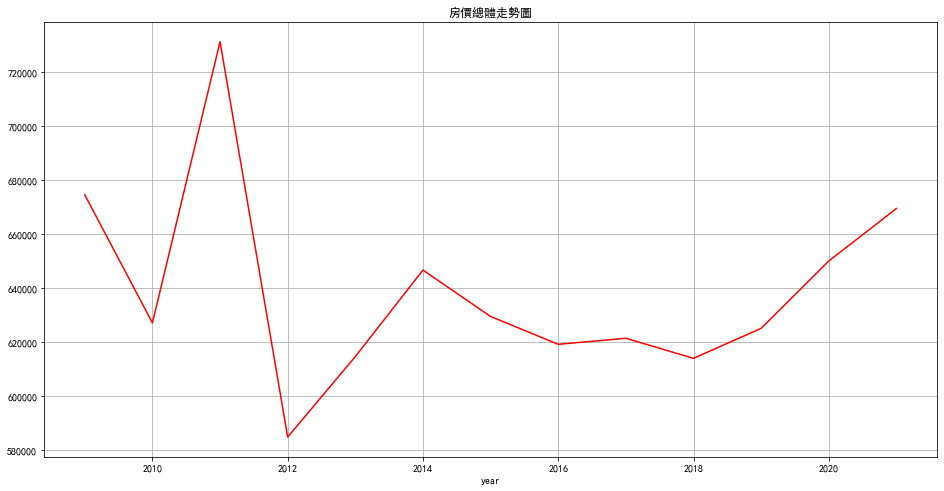

In [44]:
price_history.mean(axis=1).plot(title='房價總體走勢圖', figsize=(16,8), grid=True, c='r');

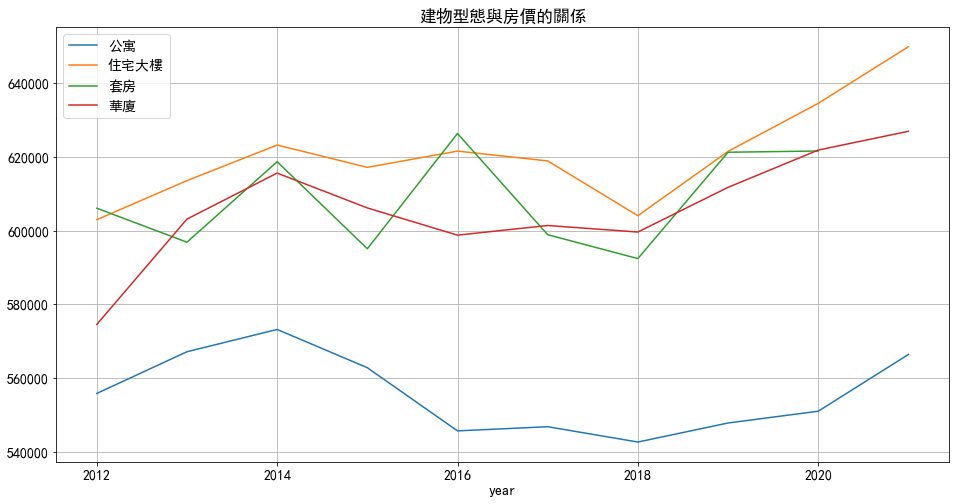

In [62]:
building_type_prices = {}
for building_type in set(df2['建物型態2']):
    cond = (
        (df2['主要用途'] == '住家用')
        & (df2['單價元坪'] < df2["單價元坪"].quantile(0.8))
        & (df2['單價元坪'] > df2["單價元坪"].quantile(0.2))
        & (df2['建物型態2'] == building_type)
        )
    building_type_prices[building_type] = df2[cond]['單價元坪'].groupby(df2[cond]['year']).mean().loc[2012:]
pd.DataFrame(building_type_prices)[['公寓', '住宅大樓', '套房', '華廈']].plot(title='建物型態與房價的關係', figsize=(16,8), grid=True);

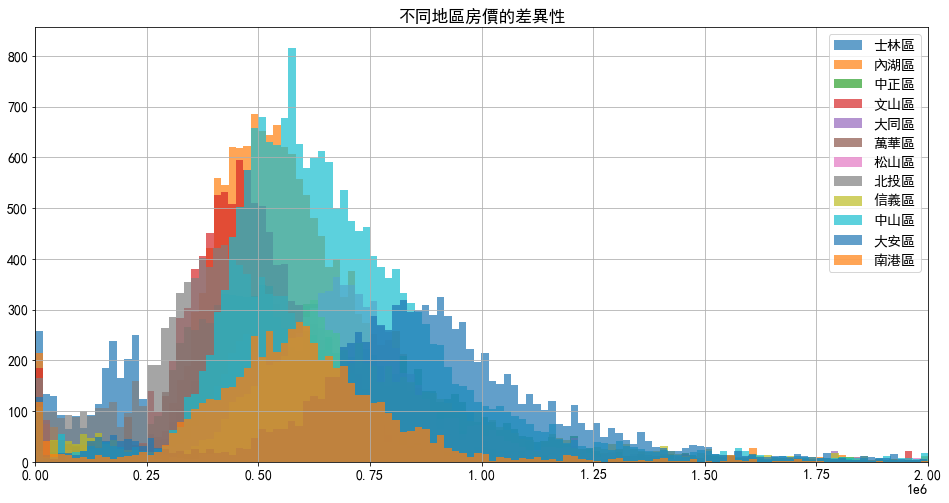

In [60]:
plt.figure(figsize=(16,8))
plt.title('不同地區房價的差異性')
plt.rcParams['font.size'] = 14
for district in set(df2['鄉鎮市區']):
    dfdistrict = df2[df2['鄉鎮市區'] == district]
    dfdistrict['單價元坪'][dfdistrict['單價元坪'] < 2000000].hist(bins=120, alpha=0.7)

plt.xlim(0, 2000000)
plt.legend(set(df2['鄉鎮市區']));

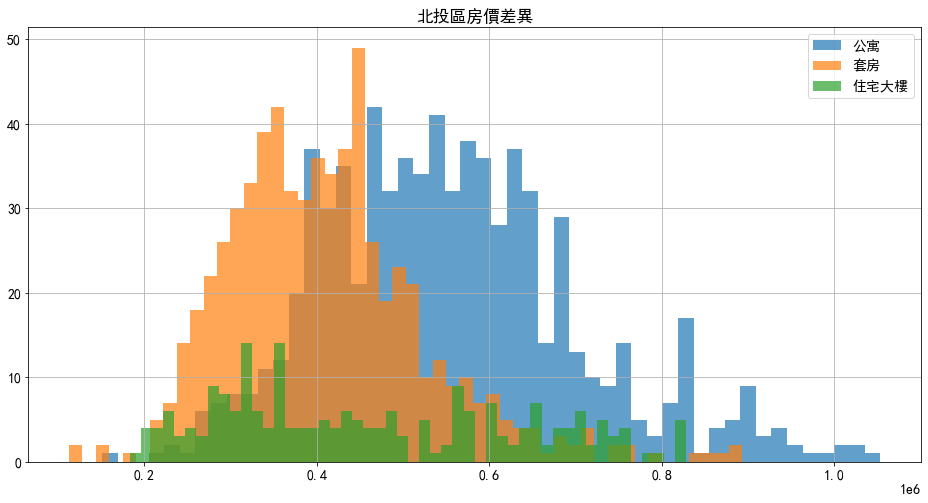

In [64]:
plt.figure(figsize=(16,8))
plt.title('北投區房價差異')
plt.rcParams['font.size'] = 14

dfdistrict = df2[(df2['鄉鎮市區'] == '北投區') & (df2['year'] >= 2018) & (
    (df2['建物型態2'] == '住宅大樓') | (df2['建物型態2'] == '公寓') | (df2['建物型態2'] == '套房')
)]
dfdistrict = dfdistrict[dfdistrict['單價元坪'] < 2000000]

dfdistrict['單價元坪'].groupby(dfdistrict['建物型態2']).hist(bins=50, alpha=0.7)
plt.legend(set(dfdistrict['建物型態2']));

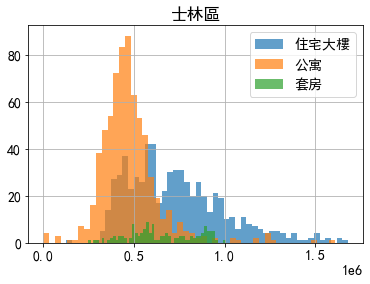

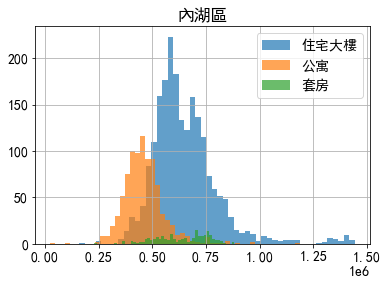

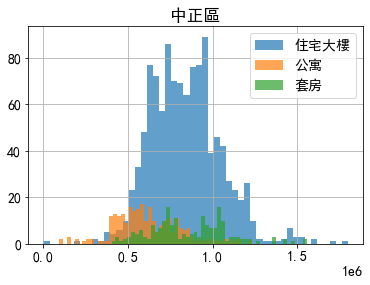

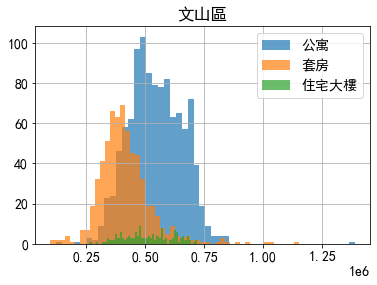

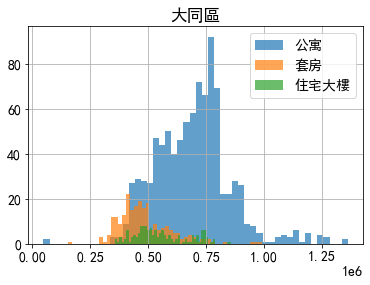

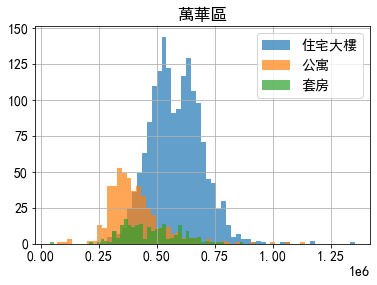

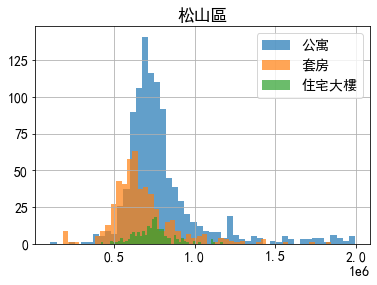

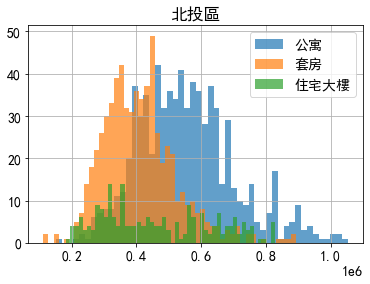

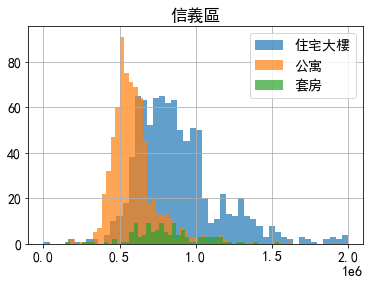

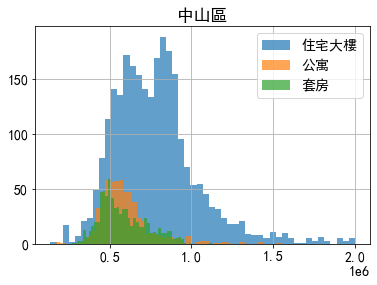

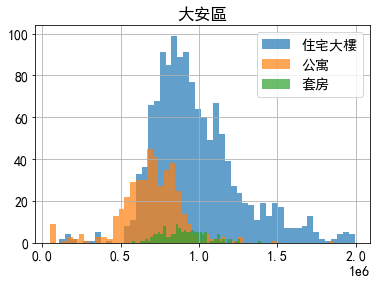

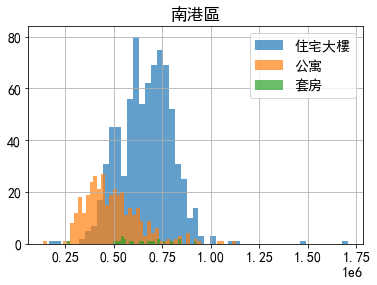

In [74]:
plt.rcParams['font.size'] = 14
for district in set(df2['鄉鎮市區']):
    dfdistrict = df2[(df2['鄉鎮市區'] == district) & (df2['year'] >= 2018) & (
        (df2['建物型態2'] == '住宅大樓') | (df2['建物型態2'] == '公寓') | (df2['建物型態2'] == '套房'))]
    dfdistrict = dfdistrict[dfdistrict['單價元坪'] < 2000000]
    plt.figure(figsize=(6,4))
    plt.title(district)
    dfdistrict['單價元坪'].groupby(dfdistrict['建物型態2']).hist(bins=50, alpha=0.7)
    plt.legend(set(dfdistrict['建物型態2']));